In [45]:
import os, json
import h5py
import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imread

%matplotlib inline

In [104]:
SCORES_FILE = 'data/scores.h5'
IMAGE_FILE = 'data/ilsvrc14-det.h5'
JSON_FILE = 'data/ilsvrc14-det.json'

with open(JSON_FILE, 'r') as f:
  json_data = json.load(f)
  val_idx_to_image_id = {int(k): v for k, v in json_data['val_idx_to_image_id'].iteritems()}

with h5py.File(SCORES_FILE, 'r') as scores_file:
  val_scores = np.asarray(scores_file['val_scores'])
  val_labels = np.asarray(scores_file['val_labels'])

print val_scores.shape, val_scores.dtype, val_labels.shape, val_labels.dtype

(20121, 200) float32 (20121, 200) uint8


In [3]:
# Dump image ids to disk
with open('data/val_image_filenames.txt', 'w') as f:
  for idx, image_id in sorted(val_idx_to_image_id.iteritems()):
    f.write('%s.JPEG\n' % image_id)

data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00000007.JPEG


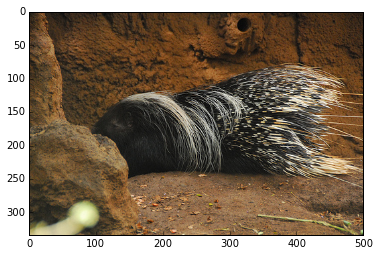

In [4]:
DET_VAL_DIR = 'data/imagenet/ILSVRC2013_DET_val'

def load_val_image(image_id):
  path = os.path.join(DET_VAL_DIR, '%s.JPEG' % image_id)
  print path
  return imread(path)

plt.imshow(load_val_image(val_idx_to_image_id[2]))

63
data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00034562.JPEG
data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00032620.JPEG
data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00025237.JPEG
data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00009638.JPEG
data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00049425.JPEG
data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00003747.JPEG
data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00034527.JPEG
data/imagenet/ILSVRC2013_DET_val/ILSVRC2012_val_00042441.JPEG


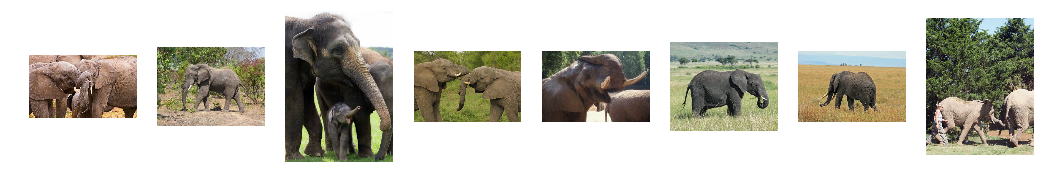

In [29]:
# As a sanity check, show the top classified images for a couple classes
name = 'elephant'
num_to_show = 8

det_id = json_data['name_to_det_id'][name] - 1
print det_id
order = np.argsort(val_scores[:, det_id])[::-1]

for i, idx in enumerate(order[:num_to_show]):
  image_id = val_idx_to_image_id[idx]
  img = load_val_image(image_id)
  plt.subplot(1, num_to_show, i + 1)
  plt.imshow(img)
  plt.axis('off')
plt.gcf().set_size_inches(18, 5)
plt.show()

In [9]:
names_subset = [
  'airplane',
  'ant',
  'bear',
  'bird',
  'camel',
  'car',
  'chair',
  'dog',
  'domestic cat',
  'drum',
  'elephant',
  'goldfish',
  'frog',
  'guitar',
  'hamburger',
  'hammer',
  'horse',
  'laptop',
  'piano',
  'pineapple',
  'miniskirt',
  'table',
  'tie',
  'tiger',
  'toaster',
  'train',
  'turtle',
  'zebra',
  'banana',
  'bowl',
  'syringe',
  'flute',
  'lamp',
  'nail',
  'spatula',
]

for name in names_subset:
  assert name in json_data['name_to_det_id']

# det ids are 1-indexed so we need to subtract one
det_ids_subset = [int(json_data['name_to_det_id'][name]) for name in names_subset]
det_ids_subset = np.asarray(det_ids_subset) - 1

print det_ids_subset

[  1   2  19  25  34  36  42  57  58  60  63  74  71  78  81  82  91 100
 124 125 111 176 180 181 182 184 187 199  12  29 175  68  99 115 164]


Num images:  8434
Overall accuracy:  0.813493004506
[[ 45.   0.   0. ...,   0.   0.   0.]
 [  0.  27.   0. ...,   0.   0.   0.]
 [  0.   0.  99. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   0. ...,  22.   0.   0.]
 [  0.   0.   0. ...,   0.  17.   0.]
 [  0.   0.   0. ...,   1.   0.  17.]]
0.813493004506


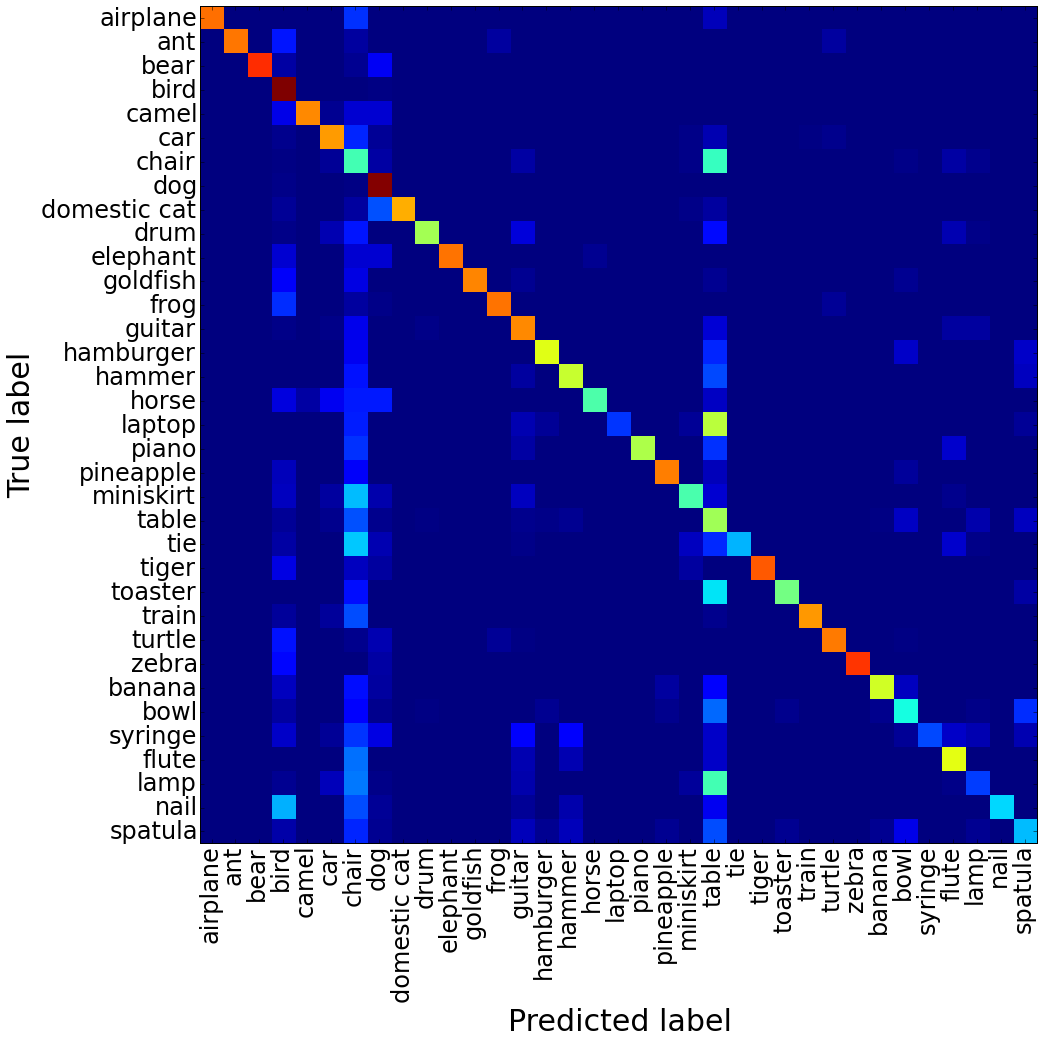

In [105]:
# Right now val_scores and val_labels are 20k x 200; we want to slice down to N x 36

val_scores_subset = val_scores[:, det_ids_subset]
val_labels_subset = val_labels[:, det_ids_subset]

# We only want images with exactly one label
img_mask = val_labels_subset.sum(axis=1) == 1
print 'Num images: ', img_mask.sum()

val_scores_subset = val_scores_subset[img_mask, :]
val_labels_subset = val_labels_subset[img_mask, :]

argmax_label = val_scores_subset.argmax(axis=1)
true_label = val_labels_subset.argmax(axis=1)

print 'Overall accuracy: ', (argmax_label == true_label).mean()

# Now actually compute the confusion matrix.
# Just use loops because I'm lazy.
num_categories = len(names_subset)
confusion = np.zeros((num_categories, num_categories))
for c1 in xrange(num_categories):
  true_label_mask = (true_label == c1)
  for c2 in xrange(num_categories):
    # How many times did we have a true label of c1 and predict a label of c2?
    argmax_label_mask = (argmax_label == c2)
    num = np.logical_and(true_label_mask, argmax_label_mask).sum()
    confusion[c1, c2] = num
    
print confusion
print np.diag(confusion).sum() / confusion.sum()

confusion_normed = confusion / confusion.sum(axis=1, keepdims=True)
plt.imshow(confusion_normed, interpolation='nearest')
plt.gcf().set_size_inches(15, 15)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('True label', fontsize=30)
plt.yticks(range(num_categories), names_subset, fontsize=24)
plt.xticks(range(num_categories), names_subset, rotation=90, fontsize=24)
plt.savefig('data/confusion.png', bbox_inches='tight')
plt.show()

airplane 61 58
ant 35 35
bear 118 117
bird 2209 2190
camel 58 56
car 571 514
chair 959 291
dog 2993 2768
domestic cat 141 104
drum 119 91
elephant 57 57
goldfish 58 57
frog 105 102
guitar 141 108
hamburger 49 31
hammer 49 36
horse 165 156
laptop 129 46
piano 55 29
pineapple 49 38
miniskirt 110 72
table 1290 483
tie 149 91
tiger 37 35
toaster 32 29
train 79 76
turtle 157 155
zebra 32 31
banana 58 37
bowl 454 221
syringe 50 46
flute 63 47
lamp 337 120
nail 67 51
spatula 88 56


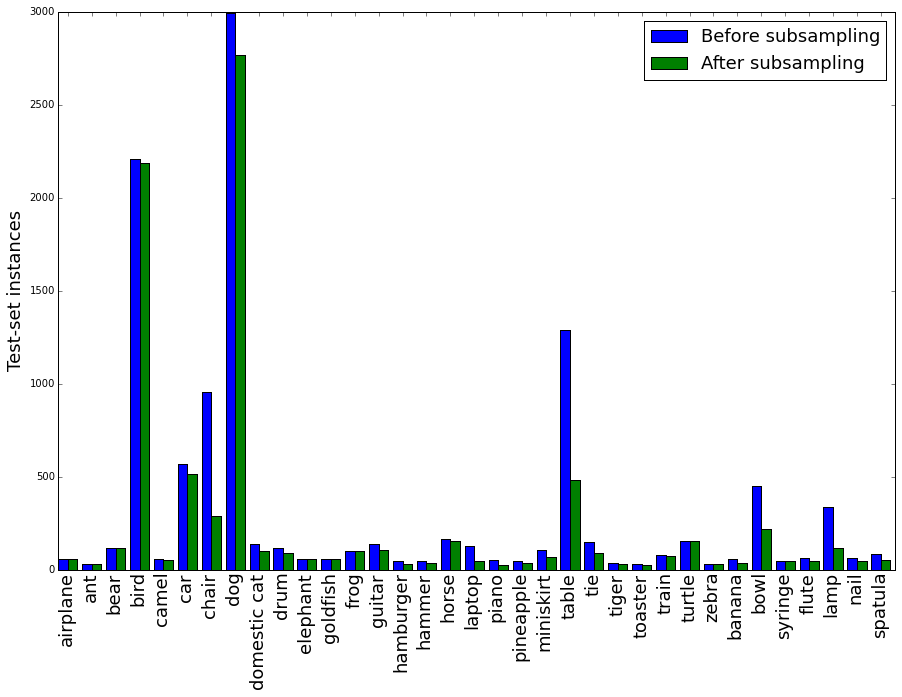

In [106]:
# Let's see how many test-set examples we have for each category

category_counts = []
category_counts_subset = []
for c in xrange(num_categories):
  num_test_one = (true_label == c).sum()
  num_test_all = val_labels[:, det_ids_subset[c]].sum()
  category_counts.append(num_test_all)
  category_counts_subset.append(num_test_one)
  print names_subset[c], num_test_all, num_test_one
  
x = np.arange(num_categories)
plt.bar(x, category_counts, width=0.4, label='Before subsampling')
plt.bar(x + 0.4, category_counts_subset, width=0.4, color='g', label='After subsampling')
plt.gcf().set_size_inches(15, 10)
plt.xticks(x+0.4, names_subset, rotation=90, size=18)
plt.ylabel('Test-set instances', size=18)
plt.legend(prop={'size': 18})
plt.savefig('data/num_examples.png', bbox_inches='tight')
plt.show()

In [100]:
# Save some stuff
from scipy.io import savemat
import cPickle as pickle

print confusion.shape

data = {
  'confusion': confusion,
  'category_names': np.asarray(names_subset, dtype=np.object),
  'category_counts': category_counts,
  'category_counts_subset': category_counts_subset,
}

with open('confusion_data.pkl', 'w') as f:
  pickle.dump(data, f)
savemat('confusion_data.mat', data)

(35, 35)
